In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import glob

In [126]:
snps_verweij = pd.read_csv('verweij_hrr50.csv')
snps_verweij['Paper'] = 'verweij_hrr50'
snps_ramirez_rec = pd.read_csv('snps_ramirez_rec.tsv', sep=' ')
snps_ramirez_rec['Paper'] = 'ramirez_hrr'
snps_ramirez_ex = pd.read_csv('snps_ramirez_ex.tsv', sep=' ')
snps_ramirez_ex['Paper'] = 'ramirez_ex'
snps_ramirez_hr = pd.read_csv('snps_ramirez_hr.tsv', sep='\t')
snps_ramirez_hr['Paper'] = 'ramirez_hr'
snps_m2pam = pd.read_csv('snps_m2pam.tsv', sep='\t')
snps_m2pam['Paper'] = 'm2pam'

In [127]:
snps_literature = set(snps_verweij['SNP']) | set(snps_ramirez_rec['SNP']) | set(snps_m2pam['SNP'])
snps_literature_df = pd.DataFrame(list(snps_literature))
snps_literature_df.to_csv('snps_literature.tsv', index=False, header=False)

In [125]:
snps_m2pam

,SNP,Weight,A1,A2,MAF,Paper
0,rs2350782,0.137661,T,C,0.114009,m2pam
1,rs6962027,0.132023,T,A,0.456869,m2pam
2,rs73158705,0.146181,A,G,0.162847,m2pam
3,rs58394792,0.118127,G,A,0.163854,m2pam
4,rs28578872,-0.195589,T,C,0.433606,m2pam
5,rs7800170,-0.061350,C,A,0.492374,m2pam


# Heart rate recovery phenotpyes

In [5]:
pheno = pd.read_csv('hrr_phenotypes/inference_hrr_given_hr_achieved.tsv', sep='\t')
pheno['FID'] = pheno['sample_id'].copy(deep=True)
pheno['IID'] = pheno['sample_id'].copy(deep=True)
pheno[['FID', 'IID', 'ecg-bike-hrr-ramp_prediction']].to_csv('hrr_phenotypes/phenotype_deep_hrr_hr_achieved.tsv', sep='\t', index=False)

In [6]:
pheno = pd.read_csv('hrr_phenotypes/baseline_hrr.tsv', sep='\t')
pheno['FID'] = pheno['sample_id'].copy(deep=True)
pheno['IID'] = pheno['sample_id'].copy(deep=True)
pheno[['FID', 'IID', 'ecg-bike-hrr-ramp_prediction']].to_csv('hrr_phenotypes/phenotype_baseline_hrr.tsv', sep='\t', index=False)

In [7]:
hrr_pheno_labels = ['HRR', 'Resting HR', 'Baseline HRR', 'Deep HRR', 'Deep HRR HR achieved', 'Deep HRR 85% Max HR']
hrr_pheno_keys = ['phenotype_hrr', 'phenotype_resting_hr', 'phenotype_baseline_hrr', 'phenotype_deep_hrr', 
                  'phenotype_deep_hrr_hr_achieved',
                  'phenotype_hrr_85_achieved_phenotype']
hrr_pheno_files = ['hrr_phenotypes/phenotype_hrr.tsv', 
                   'hrr_phenotypes/phenotype_resting_hr.tsv', 
                   'hrr_phenotypes/phenotype_baseline_hrr.tsv',
                   'hrr_phenotypes/phenotype_deep_hrr.tsv', 
                   'hrr_phenotypes/phenotype_deep_hrr_hr_achieved.tsv',
                   'hrr_phenotypes/phenotype_hrr_85_achieved_phenotype.tsv'
                  ]
hrr_dic = {}
for key, label, file in zip(hrr_pheno_keys, hrr_pheno_labels, hrr_pheno_files):
    hrr_dic[key] = {}
    hrr_dic[key]['label'] = label
    hrr_dic[key]['file'] = file
    hrr_dic[key]['df'] = pd.read_csv(file, sep='\t')

In [8]:
def sex_1m1(x):
    if x > 0.5: return 1
    if x < 0.5: return -1
def sex_mf(x):
    if x > 0.5: return 'm'
    if x < 0.5: return 'f'

In [9]:
covariates = pd.read_csv('covariate_tables_fixed.csv', sep='\t')

In [10]:
covariate_bmi = pd.read_csv('bq_bmi.csv')
covariate_bmi['BMI'] = covariate_bmi['value']
covariate_bmi = covariate_bmi[covariate_bmi['instance']==0][['sample_id', 'BMI']]
covariates = covariates.merge(covariate_bmi[['sample_id', 'BMI']], left_on='FID', right_on='sample_id')

In [11]:
covariate_hr = pd.read_csv('hrr_phenotypes/phenotype_resting_hr.tsv', sep='\t')
covariates = covariates.merge(covariate_hr[['FID', 'resting_hr']], on='FID')

In [12]:
covariates['sex'] = covariates['sex'].apply(sex_1m1)
covariates['age_sex'] = covariates['age'] * covariates['sex']
covariates['sex'] = covariates['sex'].apply(sex_mf)
covariates[['FID', 'IID', 'pc_1', 'pc_2', 'pc_3', 'pc_4', 'pc_5', 'age', 'age_sex', 'BMI', 'resting_hr']].to_csv('covariates_hrr.tsv', sep='\t', index=False)

In [30]:
pheno_yes = set(covariates['FID'])
for key in hrr_dic:
    pheno_yes = pheno_yes & set(hrr_dic[key]['df']['FID'])
#pheno_yes = set(hrr_dic['phenotype_hrr']['df']['FID'])
pheno_yes = pd.DataFrame(list(pheno_yes), columns=['FID'])
pheno_yes['IID'] = pheno_yes['FID'].copy(deep=True)
pheno_yes.to_csv('keep_ids_hrr.tsv', sep='\t', index=False)
pheno_no = pd.DataFrame(list(set(covariates['FID']) - set(pheno_yes['FID'])), columns=['FID'])
pheno_no['IID'] = pheno_no['FID'].copy(deep=True)
pheno_no[['FID', 'IID']].to_csv('exclude_ids_hrr.tsv', index=False, sep='\t')

In [31]:
len(pheno_yes)

40192

In [32]:
for key in hrr_dic:
    print(key, len(set(hrr_dic[key]['df']['FID'])))
print(len(pheno_yes))

phenotype_hrr 56126
phenotype_resting_hr 76127
phenotype_baseline_hrr 53133
phenotype_deep_hrr 53133
phenotype_deep_hrr_hr_achieved 45058
phenotype_hrr_85_achieved_phenotype 48581
40192


In [39]:
len(set(covariates['FID']) & set(hrr_dic['phenotype_resting_hr']['df']['FID']) \
    & set(hrr_dic['phenotype_deep_hrr']['df']['FID'])\
   & set(hrr_dic['phenotype_deep_hrr_hr_achieved']['df']['FID']))

40192

In [ ]:
# Now run SNPS association script

# SNPs associations

In [14]:
for key in hrr_dic:
    assocs = glob.glob(f'snps_association/{key}/*.linear')
    phenos = {assoc.split('.')[-3] for assoc in assocs}
    hrr_dic[key]['phenos'] = phenos
    for pheno in phenos:
        pheno_df = pd.DataFrame()
        for assoc in assocs:
            if assoc.split('.')[-3] == pheno:
                tmp_df = pd.read_csv(assoc, sep='\t')
                tmp_df = tmp_df[tmp_df['TEST']=='ADD']
                pheno_df = pd.concat([pheno_df, tmp_df])
        hrr_dic[key][pheno] = pheno_df
                

In [129]:
snps_ramirez_rec['P_lit'] = snps_ramirez_rec['P_f']
snps_ramirez_rec['beta_lit'] = snps_ramirez_rec['beta_f']
snps_ramirez_rec['EAF_lit'] = snps_ramirez_rec['EAF']
snps_ramirez_rec['Gene'] = snps_ramirez_rec['Locus']
snps_ramirez_rec['Paper'] = 'ramirez'
snps_verweij['P_lit'] = snps_verweij['Pval']
snps_verweij['beta_lit'] = snps_verweij['BETA']
snps_verweij['EAF_lit'] = snps_verweij['A1FREQ']
snps_verweij['Gene'] = snps_verweij['Candidate gene']
snps_verweij['Paper'] = 'verweij'
snps_m2pam['P_lit'] = 'NA'
snps_m2pam['beta_lit'] = snps_m2pam['Weight']
snps_m2pam['EAF_lit'] = 'NA'
snps_m2pam['Gene'] = 'NA'
snps_m2pam['Paper'] = 'm2pam'
snps_lit_df = pd.concat([snps_ramirez_rec[['SNP', 'Gene', 'EAF_lit', 'beta_lit', 'P_lit', 'Paper']],
                         snps_verweij[['SNP', 'Gene', 'EAF_lit', 'beta_lit', 'P_lit', 'Paper']],
                         snps_m2pam[['SNP', 'Gene', 'EAF_lit', 'beta_lit', 'P_lit', 'Paper']]
                        ])

In [174]:
gwases = ['bolt_results_hrr', 'bolt_results_resting_hr', 'bolt_results_deep_hrr', 'bolt_results_deep_hrr_hr_achieved']
for gwas in gwases:
    ff_out = open(f'/mnt/disks/gwas-results/gwas_results/{gwas}/snps.tsv', 'w')
    for bolt_results in ['bolt_output', 'bolt_imputed_snps']:
        with open(f'/mnt/disks/gwas-results/gwas_results/{gwas}/{bolt_results}', 'r') as ff:
            for line in ff:
                if line.split()[0] in snps_literature:
                    ff_out.write(line)
    ff_out.close()
            

In [193]:
gwases = ['bolt_results_hrr', 'bolt_results_resting_hr', 'bolt_results_deep_hrr', 'bolt_results_deep_hrr_hr_achieved']
labels = ['HRR', 'HR', 'HRR-pretest', 'HRR-pretest-maxHR']
gwas_dic = {}
for gwas, label in zip(gwases, labels):
    df = pd.read_csv(f'/mnt/disks/gwas-results/gwas_results/{gwas}/snps.tsv', sep='\t',
                     index_col=False,
                     names=['SNP', 'CHR', 'BP', 'GENPOS', 'ALLELE1', 'ALLELE0', 'A1FREQ',  
                            'F_MISS', 'CHISQ_LINREG', 'P_LINREG', 'BETA', 'SE', 'CHISQ_BOLT_LMM_INF',
                            'P_BOLT_LMM_INF',  'CHISQ_BOLT_LMM',  'P_BOLT_LMM']
                    )
    df = df.loc[df['SNP'].drop_duplicates().index]
    df = df.merge(snps_lit_df, on='SNP')
    gwas_dic[gwas] = {}
    gwas_dic[gwas]['df'] = df
    gwas_dic[gwas]['label'] = label


In [184]:
gwas_dic.keys()

dict_keys(['bolt_results_hrr', 'bolt_results_hrr_rbint', 'bolt_results_resting_hr', 'bolt_results_deep_hrr', 'bolt_results_deep_hrr_hr_achieved'])

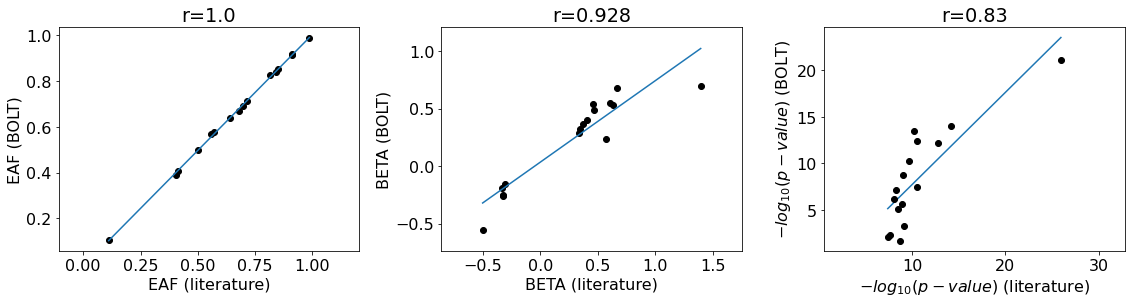

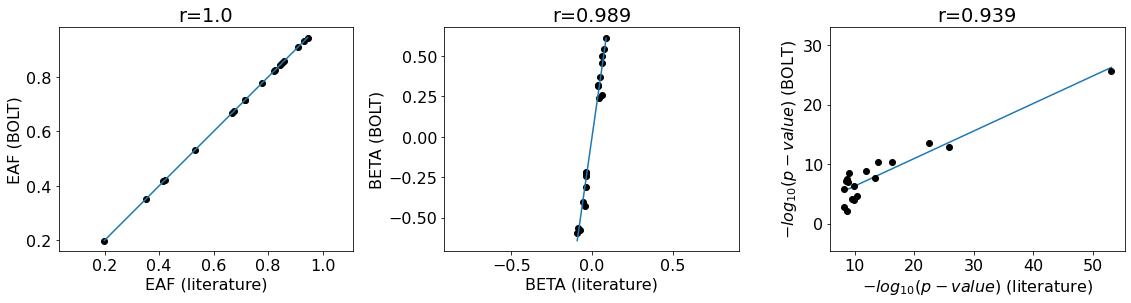

In [94]:
import matplotlib
from sklearn.linear_model import LinearRegression
font = {'family' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)
for paper in ['ramirez', 'verweij']:    
    f, ax = plt.subplots(1, 3)
    f.set_size_inches(16, 4.5)
    df_paper = gwas_dic['bolt_results_hrr'][gwas_dic['bolt_results_hrr']['Paper'] == paper]
    model = LinearRegression()
    model.fit(df_paper['EAF_lit'].values.reshape(-1, 1), df_paper['A1FREQ'].values.reshape(-1, 1))
    x_new = np.linspace(df_paper['EAF_lit'].min(), df_paper['EAF_lit'].max(), 100)
    y_new = model.predict(x_new[:, np.newaxis])
    ax[0].plot(df_paper['EAF_lit'], df_paper['A1FREQ'], 'ko')
    ax[0].plot(x_new, y_new)    
    ax[0].set_title(f'r={np.corrcoef(df_paper["A1FREQ"], df_paper["EAF_lit"])[1, 0]:.3}')
    ax[0].set_xlabel('EAF (literature)')
    ax[0].set_ylabel('EAF (BOLT)')
    ax[0].axis('equal')
    model = LinearRegression()
    model.fit(df_paper['beta_lit'].values.reshape(-1, 1), df_paper['BETA'].values.reshape(-1, 1))
    x_new = np.linspace(df_paper['beta_lit'].min(), df_paper['beta_lit'].max(), 100)
    y_new = model.predict(x_new[:, np.newaxis])    
    ax[1].plot(df_paper['beta_lit'], df_paper['BETA'], 'ko')
    ax[1].plot(x_new, y_new)
    ax[1].set_title(f'r={np.corrcoef(df_paper["beta_lit"], df_paper["BETA"])[1, 0]:.3}')
    ax[1].set_xlabel('BETA (literature)')
    ax[1].set_ylabel('BETA (BOLT)')
    ax[1].axis('equal')
    model = LinearRegression()
    model.fit(-np.log10(df_paper['P_lit'].values.reshape(-1, 1)), -np.log10(df_paper['P_BOLT_LMM'].values.reshape(-1, 1)))
    x_new = np.linspace(-np.log10(df_paper['P_lit'].min()), -np.log10(df_paper['P_lit'].max()), 100)
    y_new = model.predict(x_new[:, np.newaxis]) 
    ax[2].plot(x_new, y_new)
    ax[2].plot(-np.log10(df_paper['P_lit']), -np.log10(df_paper['P_BOLT_LMM']), 'ko')
    ax[2].set_title(f'r={np.corrcoef(-np.log10(df_paper["P_lit"]), -np.log10(df_paper["P_BOLT_LMM"]))[1, 0]:.3}')
    ax[2].set_xlabel('$-log_{10}(p-value)$ (literature)')
    ax[2].set_ylabel('$-log_{10}(p-value)$ (BOLT)')
    ax[2].axis('equal')
    plt.tight_layout()
    f.savefig(f'{paper}_sanity_bolt_results_hrr.png', dpi=300)

In [109]:
gwas_dic

{'bolt_results_hrr':             SNP  CHR         BP    GENPOS ALLELE1 ALLELE0    A1FREQ    F_MISS  \
 0     rs6795970    3   38766675  0.624799       A       G  0.387503  0.007329   
 1      rs180238    7   93550447  1.098820       C       T  0.351936  0.002980   
 2    rs17180489   14   72885471  0.662759       G       C  0.860003  0.002702   
 3    rs11589125    1   31894396  0.557434       C       T  0.944329  0.992124   
 4      rs272564    1   45012273  0.722883       A       C  0.713410  0.975381   
 5      rs272564    1   45012273  0.722883       A       C  0.713410  0.975381   
 6    rs13022107    2   60008266  0.864189       C       T  0.530928  0.971857   
 7     rs1372876    2   60025963  0.864264       A       C  0.404688  0.976822   
 8    rs73043051    3   18883863  0.382238       T       C  0.777077  0.980310   
 9     rs6549649    3   74786491  1.032040       G       C  0.569806  0.994647   
 10    rs4836027    5  121866990  1.302770       T       C  0.675435  0.986883

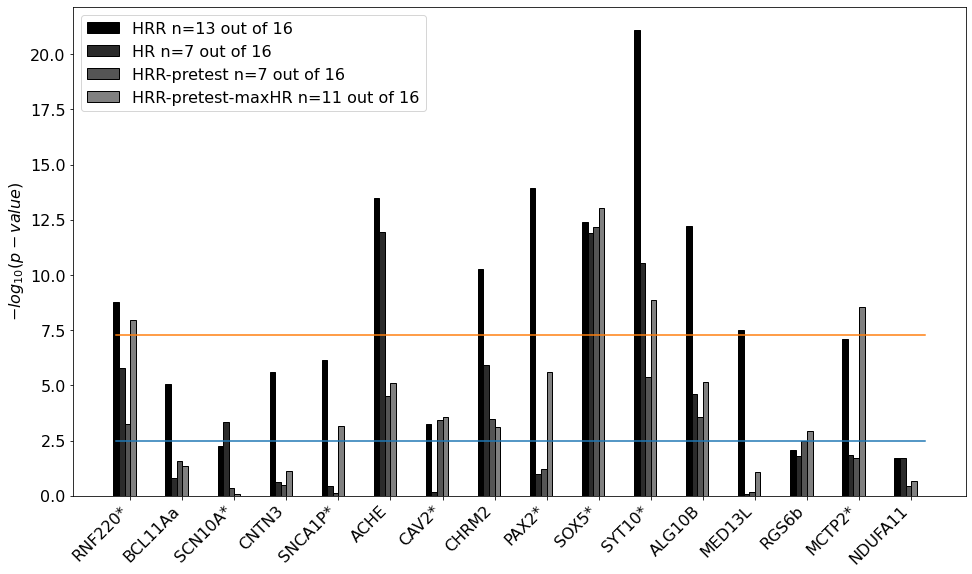

In [113]:
f, ax = plt.subplots()
xticklabels = []
xticks = []

sig_snps = np.zeros(len(gwases), dtype=np.int)
for i, snp in enumerate(snps_ramirez_rec['SNP']):    
    xs = np.arange(len(hrr_dic))*3.0 + i * (len(hrr_dic)*3.0+10)
    xticks.append(np.mean(xs))
    xticklabels.append(snps_ramirez_rec.iloc[i]['Locus'])
    arr = []
    for j, key in enumerate(gwases):      
        arr.append(float(gwas_dic[key]['df'][gwas_dic[key]['df']['SNP']==snp]['P_BOLT_LMM'].values[0]))
        if arr[-1] < (0.05/len(snps_ramirez_rec['SNP'])):
            sig_snps[j] += 1
        if i < (len(snps_ramirez_rec['SNP'])-1): 
            ax.bar(xs[j], -np.log10(arr[-1]), width=3.0, edgecolor='black',
                   color=j*np.array([1.0/(len(hrr_dic)), 1.0/(len(hrr_dic)), 1.0/(len(hrr_dic))]))
        else:
            ax.bar(xs[j], -np.log10(arr[-1]), label=f"{gwas_dic[key]['label']} n={sig_snps[j]} out of {len(snps_ramirez_rec['SNP'])}", width=3.0, edgecolor='black',
                   color=j*np.array([1.0/(len(hrr_dic)), 1.0/(len(hrr_dic)), 1.0/(len(hrr_dic))]))   
ax.legend(loc='upper left')
#ax.plot([0, np.max(xs)], [-np.log10(0.05), -np.log10(0.05)])
ax.plot([0, np.max(xs)], [-np.log10(0.05/len(snps_ramirez_rec['SNP'])), -np.log10(0.05/len(snps_ramirez_rec['SNP']))])
ax.plot([0, np.max(xs)], [-np.log10(0.05/1e6), -np.log10(0.05/1e6)])
ax.set_ylabel('$-log_{10}(p-value)$')
f.set_size_inches(16, 9)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=45, ha='right')
f.savefig('ramirez_snps_rec.png', dpi=300)

In [121]:
gwas_dic['bolt_results_hrr']['df']['SNP']

0       rs6795970
1        rs180238
2      rs17180489
3      rs11589125
4        rs272564
5        rs272564
6      rs13022107
7       rs1372876
8      rs73043051
9       rs6549649
10      rs4836027
11      rs1993875
12       rs151283
13      rs3757868
14      rs3757868
15      rs2109514
16      rs1997571
17     rs17168815
18      rs6943656
19     rs10748799
20      rs4917911
21      rs4963772
22    rs112630705
23      rs6488162
24      rs2218650
25      rs4533105
26     rs61928421
27     rs11067773
28    rs150330648
29     rs12906962
30     rs12906962
31      rs8108862
32     rs12974991
33     rs55954001
Name: SNP, dtype: object

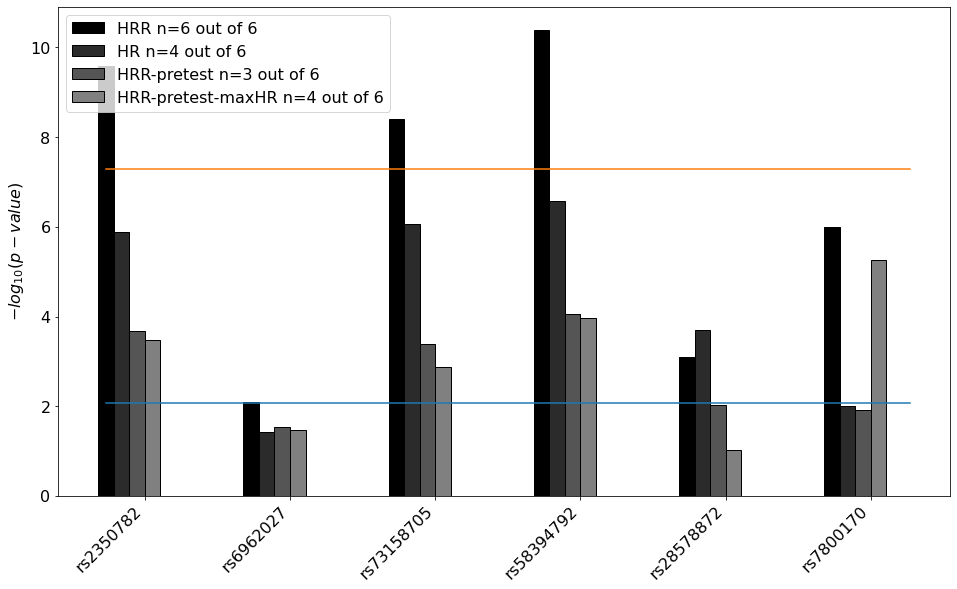

In [131]:
import matplotlib
font = {'family' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

f, ax = plt.subplots()
xticklabels = []
xticks = []

sig_snps = np.zeros(len(gwas_dic), dtype=np.int)
for i, snp in enumerate(snps_m2pam['SNP']):    
    xs = np.arange(len(hrr_dic))*3.0 + i * (len(hrr_dic)*3.0+10)
    xticks.append(np.mean(xs))
    xticklabels.append(snps_m2pam.iloc[i]['SNP'].split(',')[0])
    arr = []
    for j, key in enumerate(gwases):    
        arr.append(float(gwas_dic[key]['df'][gwas_dic[key]['df']['SNP']==snp]['P_BOLT_LMM'].values[0]))
        if arr[-1] < (0.05/len(snps_m2pam['SNP'])):
            sig_snps[j] += 1
        if i < (len(snps_m2pam['SNP'])-1): 
            ax.bar(xs[j], -np.log10(arr[-1]), width=3.0, edgecolor='black',
                   color=j*np.array([1.0/(len(hrr_dic)), 1.0/(len(hrr_dic)), 1.0/(len(hrr_dic))]))
        else:
            ax.bar(xs[j], -np.log10(arr[-1]), label=f"{gwas_dic[key]['label']} n={sig_snps[j]} out of {len(snps_m2pam['SNP'])}", width=3.0, edgecolor='black',
                   color=j*np.array([1.0/(len(hrr_dic)), 1.0/(len(hrr_dic)), 1.0/(len(hrr_dic))]))   
ax.legend(loc='upper left')
ax.plot([0, np.max(xs)], [-np.log10(0.05/len(snps_m2pam['SNP'])), -np.log10(0.05/len(snps_m2pam['SNP']))])
ax.plot([0, np.max(xs)], [-np.log10(0.05/1e6), -np.log10(0.05/1e6)])
ax.set_ylabel('$-log_{10}(p-value)$')
f.set_size_inches(16, 9)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=45, ha='right')
f.savefig('snps_m2pam.png', dpi=300)

In [214]:
gwas_dic[gwas]['df'][gwas_dic[gwas]['df']['Paper']==paper][['A1FREQ', 'EAF_lit']]

,A1FREQ,EAF_lit
0,0.387503,0.404
4,0.713410,0.716
7,0.404688,0.414
9,0.569806,0.559
11,0.691400,0.697
13,0.823925,0.815
15,0.500389,0.501
22,0.840029,0.842
26,0.106556,0.111
28,0.850611,0.851


1.0

In [230]:
gwas_dic[gwas]['df'][gwas_dic[gwas]['df']['Paper']==paper]['P_lit'].apply(float)

0     2.600000e-08
4     8.800000e-10
7     3.300000e-09
9     1.400000e-09
11    9.500000e-09
13    6.900000e-11
15    7.100000e-10
22    2.300000e-10
26    6.600000e-15
28    3.200000e-11
30    1.100000e-26
31    1.900000e-13
33    3.100000e-11
34    4.300000e-08
35    5.100000e-09
38    2.100000e-09
Name: P_lit, dtype: float64

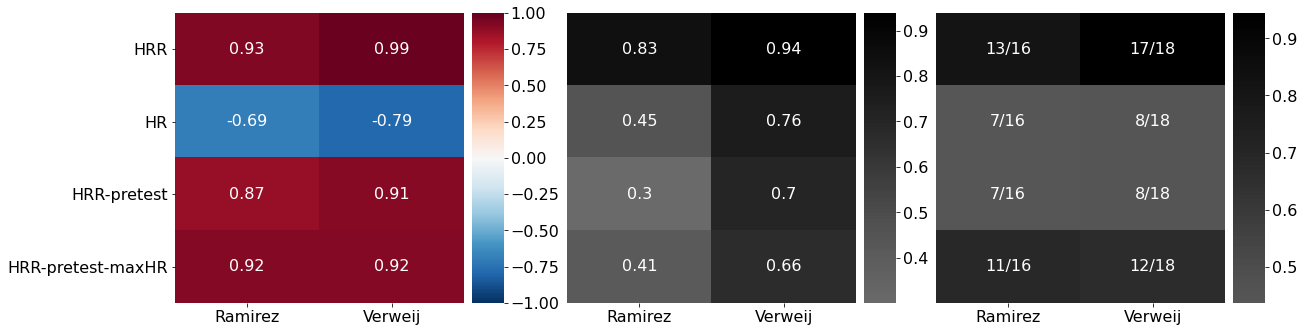

In [261]:
import matplotlib.gridspec as gridspec
f = plt.figure(constrained_layout=True)
f.set_size_inches(18, 4.5)
spec = gridspec.GridSpec(ncols=18, nrows=1, figure=f)
ax1 = f.add_subplot(spec[0:5])
ax1b = f.add_subplot(spec[5])
ax2 = f.add_subplot(spec[6:11])
ax2b = f.add_subplot(spec[11])
ax3 = f.add_subplot(spec[12:17])
ax3b = f.add_subplot(spec[17])
arr = np.zeros((4, 2))
ylabels = []
for i, gwas in enumerate(gwases):
    ylabels.append(gwas_dic[gwas]['label'])
    for j, paper in enumerate(['ramirez', 'verweij']):
        arr[i, j] = gwas_dic[gwas]['df'][gwas_dic[gwas]['df']['Paper']==paper][['BETA', 'beta_lit']].corr().iloc[0, 1]
    
sns.heatmap(arr, yticklabels=xlabels, center=0.0, xticklabels=['Ramirez', 'Verweij'], vmin=-1.0, vmax=1.0,
            annot=True, cmap='RdBu_r', ax=ax1, cbar_ax=ax1b)   

arr = np.zeros((4, 2))
ylabels = []
for i, gwas in enumerate(gwases):
    ylabels.append(gwas_dic[gwas]['label'])
    for j, paper in enumerate(['ramirez', 'verweij']):
        pval1 = -np.log10(gwas_dic[gwas]['df'][gwas_dic[gwas]['df']['Paper']==paper]['P_BOLT_LMM'])
        pval2 = -np.log10(gwas_dic[gwas]['df'][gwas_dic[gwas]['df']['Paper']==paper]['P_lit'].apply(float))
        arr[i, j] = np.corrcoef(pval1, pval2)[0, 1]    
sns.heatmap(arr, yticklabels=[], center=0.0, xticklabels=['Ramirez', 'Verweij'],
            annot=True, cmap='Greys', ax=ax2, cbar_ax=ax2b) 

arr = np.zeros((4, 2))
annot = []
ylabels = []
for i, gwas in enumerate(gwases):
    annot.append([])
    ylabels.append(gwas_dic[gwas]['label'])
    for j, paper in enumerate(['ramirez', 'verweij']):
        pval1 = gwas_dic[gwas]['df'][gwas_dic[gwas]['df']['Paper']==paper]['P_BOLT_LMM']
        sum = np.sum(pval1 < 0.05/len(gwas_dic[gwas]['df'][gwas_dic[gwas]['df']['Paper']==paper]))
        nsnps = len(gwas_dic[gwas]['df'][gwas_dic[gwas]['df']['Paper']==paper])
        arr[i, j] = sum / nsnps
        annot[-1].append(f'{sum}/{nsnps}')
sns.heatmap(arr, yticklabels=[], center=0.0, xticklabels=['Ramirez', 'Verweij'], 
            annot=annot, cmap='Greys', ax=ax3, cbar_ax=ax3b, fmt='') 
f.savefig('summary_heatmaps.png')

In [192]:
gwas_dic[gwas]['df'][gwas_dic[gwas]['df']['Paper']!='m2pam'][['BETA', 'beta_lit', 'Paper']]

,BETA,beta_lit,Paper
0,-0.012692,-0.306000,ramirez
1,-0.088355,-0.040231,verweij
2,-0.344143,-0.053700,verweij
3,-0.232578,-0.074531,verweij
4,0.268169,0.370000,ramirez
5,0.268169,0.045825,verweij
6,-0.087718,-0.035136,verweij
7,-0.084850,-0.326000,ramirez
8,-0.163660,-0.040635,verweij
9,-0.073985,-0.328000,ramirez


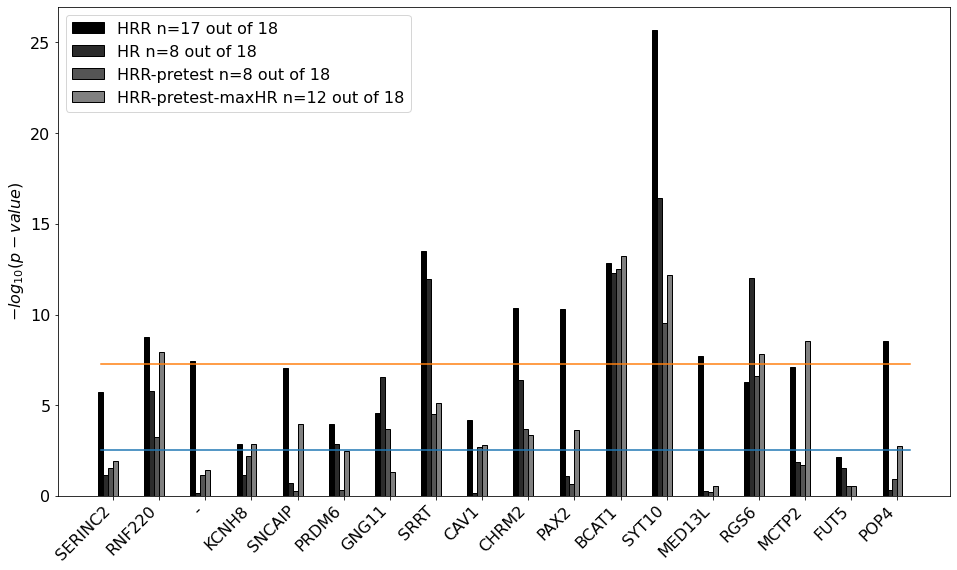

In [136]:
import matplotlib
font = {'family' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

f, ax = plt.subplots()
xticklabels = []
xticks = []

sig_snps = np.zeros(len(hrr_pheno_keys), dtype=np.int)
for i, snp in enumerate(snps_verweij['SNP']):    
    xs = np.arange(len(hrr_dic))*3.0 + i * (len(hrr_dic)*3.0+10)
    xticks.append(np.mean(xs))
    xtick_label = snps_verweij.iloc[i]['Candidate gene'].split(',')[0]
    xticklabels.append(xtick_label)
    arr = []
    for j, key in enumerate(gwases):    
        arr.append(float(gwas_dic[key]['df'][gwas_dic[key]['df']['SNP']==snp]['P_BOLT_LMM'].values[0]))
        if arr[-1] < (0.05/len(snps_verweij['SNP'])):
            sig_snps[j] += 1
        if i < (len(snps_verweij['SNP'])-1): 
            ax.bar(xs[j], -np.log10(arr[-1]), width=3.0, edgecolor='black',
                   color=j*np.array([1.0/(len(hrr_dic)), 1.0/(len(hrr_dic)), 1.0/(len(hrr_dic))]))
        else:
            ax.bar(xs[j], -np.log10(arr[-1]), label=f"{gwas_dic[key]['label']} n={sig_snps[j]} out of {len(snps_verweij['SNP'])}", width=3.0, edgecolor='black',
                   color=j*np.array([1.0/(len(hrr_dic)), 1.0/(len(hrr_dic)), 1.0/(len(hrr_dic))]))   
ax.legend(loc='upper left')
ax.plot([0, np.max(xs)], [-np.log10(0.05/len(snps_verweij['SNP'])), -np.log10(0.05/len(snps_verweij['SNP']))])
ax.plot([0, np.max(xs)], [-np.log10(0.05/1e6), -np.log10(0.05/1e6)])
ax.set_ylabel('$-log_{10}(p-value)$')
f.set_size_inches(16, 9)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=45, ha='right')
f.savefig('verweij_snps_hrr50.png', dpi=300)

In [ ]:


f, ax = plt.subplots()
xticklabels = []
xticks = []

sig_snps = np.zeros(len(hrr_pheno_keys), dtype=np.int)
for i, snp in enumerate(snps_ramirez_rec['SNP']):    
    xs = np.arange(len(hrr_dic))*3.0 + i * (len(hrr_dic)*3.0+10)
    xticks.append(np.mean(xs))
    xticklabels.append(snps_ramirez_rec.iloc[i]['Locus'])
    arr = []
    for j, key in enumerate(hrr_pheno_keys):
        for pheno in hrr_dic[key]['phenos']:
            if ('rbint' in pheno) or ('_actual' in pheno): continue        
        arr.append(float(hrr_dic[key][pheno][hrr_dic[key][pheno]['ID']==snp]['P'].values[0]))
        if arr[-1] < (0.05/len(snps_ramirez_rec['SNP'])):
            sig_snps[j] += 1
        if i < (len(snps_ramirez_rec['SNP'])-1): 
            ax.bar(xs[j], -np.log10(arr[-1]), width=3.0, edgecolor='black',
                   color=j*np.array([1.0/(len(hrr_dic)), 1.0/(len(hrr_dic)), 1.0/(len(hrr_dic))]))
        else:
            ax.bar(xs[j], -np.log10(arr[-1]), label=f"{hrr_dic[key]['label']} n={sig_snps[j]} out of {len(snps_ramirez_rec['SNP'])}", width=3.0, edgecolor='black',
                   color=j*np.array([1.0/(len(hrr_dic)), 1.0/(len(hrr_dic)), 1.0/(len(hrr_dic))]))   
ax.legend(loc='upper left')
#ax.plot([0, np.max(xs)], [-np.log10(0.05), -np.log10(0.05)])
ax.plot([0, np.max(xs)], [-np.log10(0.05/len(snps_ramirez_rec['SNP'])), -np.log10(0.05/len(snps_ramirez_rec['SNP']))])
ax.plot([0, np.max(xs)], [-np.log10(0.05/1e6), -np.log10(0.05/1e6)])
ax.set_ylabel('$-log_{10}(p-value)$')
f.set_size_inches(16, 9)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=45, ha='right')
f.savefig('ramirez_snps_rec.png', dpi=300)

In [ ]:
import scipy.stats as ss
sel = hrr_dic['phenotype_hrr']['hrr'].merge(snps_ramirez_rec, left_on='ID', right_on='SNP')
sel["P"] = sel["P"].apply(float)
ss.pearsonr(sel['BETA'], sel['beta_f'])

# f, ax = plt.subplots(1, 2)
# f.set_size_inches(16, 6)
# ax[0].plot(sel['beta_f'], sel['BETA'], 'o')
# ax[1].plot(-np.log10(sel['P']), -np.log10(sel['P_f']), 'o')

In [ ]:
gwases_cross['deephrr']['verweij'][['BETA', 'Pval']]

In [ ]:
import matplotlib
font = {'family' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

f, ax = plt.subplots()
xticklabels = []
xticks = []

sig_snps = np.zeros(len(hrr_pheno_keys), dtype=np.int)
for i, snp in enumerate(snps_verweij['SNP']):    
    xs = np.arange(len(hrr_dic))*3.0 + i * (len(hrr_dic)*3.0+10)
    xticks.append(np.mean(xs))
    xticklabels.append(snps_verweij.iloc[i]['Candidate gene'].split(',')[0])
    arr = []
    for j, key in enumerate(hrr_pheno_keys):
        for pheno in hrr_dic[key]['phenos']:
            if ('rbint' in pheno) or ('_actual' in pheno): continue        
        arr.append(float(hrr_dic[key][pheno][hrr_dic[key][pheno]['ID']==snp]['P'].values[0]))
        if arr[-1] < (0.05/len(snps_verweij['SNP'])):
            sig_snps[j] += 1
        if i < (len(snps_verweij['SNP'])-1): 
            ax.bar(xs[j], -np.log10(arr[-1]), width=3.0, edgecolor='black',
                   color=j*np.array([1.0/(len(hrr_dic)), 1.0/(len(hrr_dic)), 1.0/(len(hrr_dic))]))
        else:
            ax.bar(xs[j], -np.log10(arr[-1]), label=f"{hrr_dic[key]['label']} n={sig_snps[j]} out of {len(snps_verweij['SNP'])}", width=3.0, edgecolor='black',
                   color=j*np.array([1.0/(len(hrr_dic)), 1.0/(len(hrr_dic)), 1.0/(len(hrr_dic))]))   
ax.legend(loc='upper left')
ax.plot([0, np.max(xs)], [-np.log10(0.05/len(snps_verweij['SNP'])), -np.log10(0.05/len(snps_verweij['SNP']))])
ax.plot([0, np.max(xs)], [-np.log10(0.05/1e6), -np.log10(0.05/1e6)])
ax.set_ylabel('$-log_{10}(p-value)$')
f.set_size_inches(16, 9)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=45, ha='right')
f.savefig('verweij_snps_hrr50.png', dpi=300)

In [ ]:
import matplotlib
font = {'family' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

f, ax = plt.subplots()
xticklabels = []
xticks = []

sig_snps = np.zeros(len(hrr_pheno_keys), dtype=np.int)
for i, snp in enumerate(snps_m2pam['SNP']):    
    xs = np.arange(len(hrr_dic))*3.0 + i * (len(hrr_dic)*3.0+10)
    xticks.append(np.mean(xs))
    xticklabels.append(snps_m2pam['SNP'].iloc[i])
    arr = []
    for j, key in enumerate(hrr_pheno_keys):
        for pheno in hrr_dic[key]['phenos']:
            if ('rbint' in pheno) or ('_actual' in pheno): continue        
        arr.append(float(hrr_dic[key][pheno][hrr_dic[key][pheno]['ID']==snp]['P'].values[0]))
        if arr[-1] < (0.05/len(snps_m2pam['SNP'])):
            sig_snps[j] += 1
        if i < (len(snps_m2pam['SNP'])-1): 
            ax.bar(xs[j], -np.log10(arr[-1]), width=3.0, edgecolor='black',
                   color=j*np.array([1.0/(len(hrr_dic)), 1.0/(len(hrr_dic)), 1.0/(len(hrr_dic))]))
        else:
            ax.bar(xs[j], -np.log10(arr[-1]), label=f"{hrr_dic[key]['label']} n={sig_snps[j]} out of {len(snps_m2pam['SNP'])}", width=3.0, edgecolor='black',
                   color=j*np.array([1.0/(len(hrr_dic)), 1.0/(len(hrr_dic)), 1.0/(len(hrr_dic))]))   
ax.legend(loc='upper left')
ax.plot([0, np.max(xs)], [-np.log10(0.05/len(snps_m2pam['SNP'])), -np.log10(0.05/len(snps_m2pam['SNP']))])
ax.plot([0, np.max(xs)], [-np.log10(0.05/1e6), -np.log10(0.05/1e6)])
ax.set_ylabel('$-log_{10}(p-value)$')
f.set_size_inches(16, 9)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=45, ha='right')
f.savefig('ramirez_snps_m2pam.png', dpi=300)

In [ ]:
sel[['REF', 'ALT', 'A1', 'EA', 'EAF']]

In [ ]:
hrr_dic

In [ ]:
# # Filter GWAS results
# gwas_dirs = glob.glob('gwas_results/*')
# gwases = {}
# for gwas_dir in gwas_dirs:
#     gwas = ''.join(gwas_dir.split('/')[-1].split('_')[2:])
#     output = pd.read_csv(f'{gwas_dir}/bolt_output', sep='\t', 
#                          usecols=['SNP', 'CHR', 'BP', 'BETA', 'ALLELE1', 'ALLELE0', 'P_BOLT_LMM'])
#     imputed = pd.read_csv(f'{gwas_dir}/bolt_imputed_snps', sep='\t', 
#                           usecols=['SNP', 'CHR', 'BP', 'BETA', 'ALLELE1', 'ALLELE0', 'P_BOLT_LMM'])
#     gwases[gwas] = pd.concat([output[output['P_BOLT_LMM']<0.1], imputed[imputed['P_BOLT_LMM']<0.1]])
#     gwases[gwas].to_csv(f'{gwas_dir}/filtered_snps.tsv', sep='\t', index=False)

In [ ]:
# Read GWAS results
gwas_dirs = glob.glob('/mnt/disks/gwas-results/gwas_results/*')
gwases = {}
for gwas_dir in gwas_dirs:
    gwas = ''.join(gwas_dir.split('/')[-1].split('_')[2:])
    gwases[gwas] = pd.read_csv(f'{gwas_dir}/filtered_snps.tsv', sep='\t')
    idx = gwases[gwas]['SNP'].drop_duplicates().index
    gwases[gwas] = gwases[gwas].loc[idx]

In [ ]:
gwa.keys()

In [ ]:
gwases['hrr'][gwases['hrr']['SNP']=='rs4963772']

In [ ]:
set(snps_ramirez_rec['SNP']) & set(snps_verweij['SNP'])

In [ ]:
gwases_cross = {}
for gwas in gwases:
    gwases_cross[gwas] = {}
    gwases_cross[gwas]['ramirez_rec'] = snps_ramirez_rec.merge(gwases[gwas], how='left', on='SNP', indicator=True)
    gwases_cross[gwas]['verweij'] = snps_verweij.merge(gwases[gwas], how='left', on='SNP', indicator=True)

In [ ]:
gwases_cross['hrr']['verweij'].keys()

In [ ]:
gwases_cross['hrrrbint']['ramirez_rec'][['beta_f', 'BETA']].corr()

In [ ]:
ss.pearsonr(gwases_cross['hrr']['verweij']['Pval'], gwases_cross['hrr']['verweij']['P_BOLT_LMM'])

In [ ]:
hrr_dic['phenotype_hrr']['hrr'].merge(snps_verweij, left_on='ID', right_on='SNP')[['BETA_x', 'BETA_y']].corr()

In [ ]:
import matplotlib
font = {'family' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

f, ax = plt.subplots()
xticklabels = []
xticks = []
gwases_keys = list(gwases.keys())
gwases_keys = ['hrr', 'restinghr', 'deephrr', 'deephrrtransfer']
gwases_labels = ['HRR', 'Resting HR', 'HRR from pretest', 'HRR from pretest and resting']
for i, snp in enumerate(snps_ramirez_rec['SNP']):
    xs = np.arange(len(gwases_keys))*3.0 + i * (len(gwases_keys)*3.0+10)
    xticks.append(np.mean(xs))
    xticklabels.append(snps_ramirez_rec.iloc[i]['Locus'])
    arr = []
    for j, gwas in enumerate(gwases_keys):
        arr.append(gwases_cross[gwas]['ramirez_rec'].iloc[i]['P_BOLT_LMM'])
        ax.bar(xs[j], -np.log10(arr[-1]), label=gwases_labels[j], width=3.0, edgecolor='black',
               color=j*np.array([0.3, 0.3, 0.3]))
    if i == 0 : 
        ax.legend(loc='upper left')
ax.plot([0, np.max(xs)], [-np.log10(0.05/16.0), -np.log10(0.05/16.0)])
ax.plot([0, np.max(xs)], [-np.log10(0.05/1e6), -np.log10(0.05/1e6)])
ax.set_ylabel('$-log_{10}(p-value)$')
f.set_size_inches(16, 9)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=45, ha='right')
f.savefig('ramirez_rec.png', dpi=300)

In [ ]:
snps_ramirez_rec

In [ ]:
snps_ramirez_ex

In [ ]:
f, ax = plt.subplots()
xticklabels = []
xticks = []
gwases_keys = list(gwases.keys())
gwases_keys = ['hrr', 'restinghr', 'deephrr', 'deephrrtransfer']
for i, snp in enumerate(snps_verweij['SNP']):
    xs = np.arange(len(gwases_keys))*8.0 + i * (len(gwases_keys)*8.0+10)
    xticks.append(np.mean(xs))
    xticklabels.append(snps_verweij.iloc[i]['Candidate gene'].split(',')[0])
    arr = []
    for j, gwas in enumerate(gwases_keys):
        arr.append(gwases_cross[gwas]['verweij'].iloc[i]['P_BOLT_LMM'])
        ax.bar(xs[j], -np.log10(arr[-1]), label=gwases_labels[j], width=8, edgecolor='black',
               color=j*np.array([0.3, 0.3, 0.3]))
    if i == 0 : 
        ax.legend()
ax.plot([0, np.max(xs)], [-np.log10(0.05/23.0), -np.log10(0.05/23.0)])
ax.plot([0, np.max(xs)], [-np.log10(0.05/1e6), -np.log10(0.05/1e6)])
f.set_size_inches(16, 9)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=45, ha='right')
f.savefig('verweij.png', dpi=300)

In [ ]:
snps_vandervej

In [ ]:
gwases.keys()

In [ ]:
f, ax = plt.subplots()
xticklabels = []
xticks = []
gwases_keys = list(gwases.keys())
gwases_keys = ['hrr', 'restinghr', 'deephrr', 'deephrrtransfer']
for i, snp in enumerate(snps_m2pam['SNP']):
    xs = np.arange(len(gwases_keys))*3.0 + i * (len(gwases_keys)*3.0+10)
    xticks.append(np.mean(xs))
    xticklabels.append(snps_m2pam.iloc[i]['SNP'])
    arr = []
    for j, gwas in enumerate(gwases_keys):
        arr.append(gwases_cross[gwas]['m2pam'].iloc[i]['P_BOLT_LMM'])
        ax.bar(xs[j], -np.log10(arr[-1]), label=gwases_labels[j], width=3, edgecolor='black',
               color=j*np.array([0.3, 0.3, 0.3]))
    if i == 0 : 
        ax.legend()
ax.plot([0, np.max(xs)], [-np.log10(0.05/6.0), -np.log10(0.05/6.0)])
ax.plot([0, np.max(xs)], [-np.log10(0.05/1e6), -np.log10(0.05/1e6)])
f.set_size_inches(16, 9)
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels, rotation=45, ha='right')
f.savefig('m2pam.png')

In [ ]:
gwases['hrr']

In [ ]:
def plot_gwas(df_tmp, fig, ax):
    df = df_tmp.sort_values(by=['CHR', 'BP'])
    df['LOGP'] = -np.log10(df['P_BOLT_LMM'])
    df.CHR = df.CHR.astype('category')
    df['ind'] = range(len(df))
    df_grouped = df.groupby(('CHR'))
       
    colors = ['black','silver']
    x_labels = []
    x_labels_pos = []

    for num, (name, group) in enumerate(df_grouped):
        group.plot(kind='scatter', x='ind', y='LOGP',color=colors[num % len(colors)], ax=ax, s=5)
        x_labels.append(name)
        x_labels_pos.append((group['ind'].iloc[-1] - (group['ind'].iloc[-1] - group['ind'].iloc[0])/2))   
        
    ax.plot([0.0, group['ind'].iloc[-1]], [7.3, 7.3])
    
    ax.set_xticks(x_labels_pos)
    ax.set_xticklabels(x_labels)
    ax.set_xlim([0, len(df)])
    ax.set_ylim([1, 20])
    ax.set_xlabel('Chromosome')
    ax.set_ylabel('$-\log_{10}(p-value)$')

In [ ]:
for gwas in gwases:
    f, ax = plt.subplots()
    f.set_size_inches(22, 6)
    plot_gwas(gwases[gwas], f, ax)
    f.savefig(f'manhattan_{gwas}.png', dpi=300)

In [ ]:
from assocplots.qqplot import *

In [ ]:
# Filter GWAS results
gwas_dirs = glob.glob('gwas_results/*')
gwases_outputs = {}
for gwas_dir in gwas_dirs:
    gwas = ''.join(gwas_dir.split('/')[-1].split('_')[2:])
    output = pd.read_csv(f'{gwas_dir}/bolt_output', sep='\t', 
                         usecols=['SNP', 'CHR', 'BP', 'BETA', 'ALLELE1', 'ALLELE0', 'A1FREQ', 'P_BOLT_LMM'])
    # imputed = pd.read_csv(f'{gwas_dir}/bolt_imputed_snps', sep='\t', 
    #                      usecols=['SNP', 'CHR', 'BP', 'BETA', 'ALLELE1', 'ALLELE0', 'P_BOLT_LMM'])
    gwases_outputs[gwas] = output

In [ ]:
for gwas in gwases_outputs:
    f, ax = plt.subplots()
    f.set_size_inches(6, 6)
    qqplot([gwases_outputs[gwas]['P_BOLT_LMM']], 
           [gwas], 
           color=['k'], 
           fill_dens=[0.2], 
           error_type='theoretical', 
           distribution='beta',
           title='')
    f.savefig(f'qq_{gwas}.png', dpi=300)

In [ ]:
f, ax = plt.subplots()
f.set_size_inches(5, 5)
plt.sca(ax)
qqplot([gwas_dic['HRR']['P_BOLT_LMM']], 
       ['HRR (UKBB)'], 
       color=['k'], 
       fill_dens=[0.2], 
       error_type='theoretical', 
       distribution='beta',
       title='HRR (UKBB)')
f.savefig('HRR_qq.png')

# plt.sca(ax[1])
# qqplot([df_deep_hrr['P_BOLT_LMM']], 
#        ['HRR from pretest'], 
#        color=['k'], 
#        fill_dens=[0.2], 
#        error_type='theoretical', 
#        distribution='beta',
#        title='HRR from pretest')

# plt.sca(ax[2])
# qqplot([df_deep_transfer['P_BOLT_LMM']], 
#        ['HRR from pretest and resting ECGs'], 
#        color=['k'], 
#        fill_dens=[0.2], 
#        error_type='theoretical', 
#        distribution='beta',
#        title='HRR from pretest and resting ECGs')